# A Comprehensive Introduction of Medusa
Sept, 2023 | 45 min | Yuhong Li

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6" # define GPU id, remove if you want to use all GPUs available
import torch
from contextlib import contextmanager
import numpy as np
from loaa.model.loaa_model import LoaaModel
from loaa.model.kv_cache import *
from loaa.model.utils import *
from loaa.model.loaa_choices import *
from copy import deepcopy
import matplotlib.pyplot as plt
from loaa.model.modeling_llama_kv import LlamaForCausalLM as KVLlamaForCausalLM

import transformers
from loaa.model.loaa_model import LoaaModel, LoaaConfig
from safetensors.torch import load_file


/home/taehyeon/miniconda3/envs/loaa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## How LLM inference?

In this section, we will illustrate LLM inference with KV cache mechanism.

The Key-Value (KV) cache mechanism serves as a rapid-access storage during inference. By retaining the model's intermediate KV features from previous inferences in this cache, computation time can be substantially reduced.


Consider an example where the incoming input token has a shape of `[1, 1]`, denoting a batch_size of 1 and a sequence_length of 1. If the model has prior intermediate KV features stored in the cache, the inference will proceed as follows:


1. **Embedding Mapping**: The model transforms the input token into an embedding vector, resulting in a shape of `[1, 1, hidden_size]`.

2. **Forward through FFN**: This embedded vector is then passed through the Feed Forward Network (FFN) module, yielding an output with the same shape: `[1, 1, hidden_size]`.

3. **Attention Mechanism**: 

    * The query vector for the current token is reshaped and transformed from `[1, 1, hidden_size]` to `[1, 1, num_heads, head_dim]` to `[1, num_heads, 1, head_dim]`.
    * The cached intermediate KV vectors from previous inferences have the shape `[1, num_heads, prev_kv_seq_len, head_dim]`.
    * Current KV vectors are concatenated with these cached KV vectors, resulting in a new shape of `[1, num_heads, prev_kv_seq_len + 1, head_dim]`.
    * Hence, the QK matrix's shape is `[1, num_heads, 1, head_dim] x [1, num_heads, head_dim, prev_kv_seq_len + 1]` -> `[1, num_heads, 1, prev_kv_seq_len + 1]`.
    * The (QK)V matrix's shape is `[1, num_heads, 1, prev_kv_seq_len + 1] x [1, num_heads, prev_kv_seq_len + 1, head_dim]` -> `[1, num_heads, 1, head_dim]`.
    * The output is transformed and reshaped to `[1, 1, hidden_size]`.

Without the KV cache mechanism, the inference will proceed the **whole sequence** each time, resulting in significantly larger QK matrix and slower FFN computation.

If you want to know more about KV cache, please refer to the awesome [blog](https://www.dipkumar.dev/becoming-the-unbeatable/posts/gpt-kvcache/).

Let's try an example with KV cache inference:

In [2]:
model_name_or_path = 'lmsys/vicuna-7b-v1.3'
CACHE_DIR = '/mnt/data1/taehyeon/'

config = transformers.AutoConfig.from_pretrained(
        model_name_or_path,
        cache_dir=CACHE_DIR,
    )

model = KVLlamaForCausalLM.from_pretrained(
    model_name_or_path,
    config=config,
    cache_dir=CACHE_DIR,
    torch_dtype=torch.bfloat16,
)

loaa_config = LoaaConfig(
    loaa_num_heads=6,
    loaa_num_layers=1,
    loaa_width = 0.25,
    base_model_name_or_path=model_name_or_path,
    shortcut = True,
    cache_dir=CACHE_DIR,
)

model = LoaaModel(loaa_config, model)

Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.59s/it]
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
loaa_path = '../loaa_6_width_0.25_self_shortcut/loaa_lm_head.safetensors'
state_dict = load_file(loaa_path)
model.loaa_head.load_state_dict(state_dict, strict=True)
model.loaa_head = model.loaa_head.bfloat16()

model = model.cuda()
tokenizer = model.get_tokenizer()

### Initialize the kv_cache

In [4]:
past_key_values, past_key_values_data, current_length_data = initialize_past_key_values(model.base_model)
model.past_key_values = past_key_values
model.past_key_values_data = past_key_values_data
model.current_length_data = current_length_data

### Set the prompt

The prompt is as follow:

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:

In [5]:
model.current_length_data.zero_() # this is for rerun
prompt = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:"
print(prompt)
input_ids = tokenizer([prompt]).input_ids
input_len = len(input_ids[0])
print('Input token length:', len(input_ids[0]))
print('Init KV cache shape for attention modules:', model.past_key_values[0][0].shape, model.past_key_values[0][1].shape)

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: Hi, could you share a tale about a charming llama that grows Medusa-like hair and starts its own coffee shop? ASSISTANT:
Input token length: 66
Init KV cache shape for attention modules: (1, 32, 0, 128) (1, 32, 0, 128)


### First inference for all the prompt tokens

You can see the input is the prompt which contains 66 tokens. The output is the logits (`batchsize x seq_len x class`) of the predicted next token for each token in the prompt.

In [6]:
output = model.base_model.model(torch.as_tensor(input_ids).cuda(), past_key_values=model.past_key_values,)
orig  = model.base_model.lm_head(output[0])
print(len((input_ids[0])), orig.shape)
orig1 = output[0].clone()
new = torch.cat([output[0], orig1], dim=-1)
a= torch.chunk(new, 2, dim=-1)
torch.stack(a, dim=0).shape

66 torch.Size([1, 66, 32000])


torch.Size([2, 1, 66, 4096])

In [7]:
with torch.inference_mode():
    model.current_length_data.zero_() # this is for rerun
    output = model.base_model(torch.as_tensor(input_ids).cuda(), past_key_values=model.past_key_values,)
    print('output shape:', output.logits.shape)
    pred = output.logits.argmax(-1)
    input_ids[0] = input_ids[0] + pred[0, -1:].tolist()
    print('KV cache shape for attention modules after first inference:', model.past_key_values[0][0].shape, model.past_key_values[0][1].shape)
    print('First prediction:', tokenizer.batch_decode(pred[..., -1:]))

output shape: torch.Size([1, 66, 32000])
KV cache shape for attention modules after first inference: (1, 32, 66, 128) (1, 32, 66, 128)
First prediction: ['Once']


### Second inference using the kv_cache
You can see we utilize the KV cache to streamline our computations. Instead of feeding the entire prompt with new tokens to the model again, we only input the token that was predicted in the previous inference step. Notice this time the output `seq_len = 1`.

In [8]:
with torch.inference_mode():
    output = model.base_model(pred[..., -1:], past_key_values=model.past_key_values, use_cache=True) # note we only need to put last token in the input_ids
    print('output shape:', output.logits.shape)
    pred = output.logits.argmax(-1)
    input_ids[0] = input_ids[0] + pred[0, -1:].tolist()
    print('KV cache shape for attention modules after second inference:', model.past_key_values[0][0].shape, model.past_key_values[0][1].shape)
    print('Second prediction:', tokenizer.batch_decode(pred[..., -1:]))

output shape: torch.Size([1, 1, 32000])
KV cache shape for attention modules after second inference: (1, 32, 67, 128) (1, 32, 67, 128)
Second prediction: ['upon']


In [9]:
with torch.inference_mode():
    for _ in range(10):
        output = model.base_model(pred[..., -1:], past_key_values=model.past_key_values, use_cache=True)
        pred = output.logits.argmax(-1)
        # pred_topk = output.logits.topk(10, dim = -1).indices[0]
        input_ids[0] = input_ids[0] + pred[0, -1:].tolist()
        print(tokenizer.batch_decode(pred[..., -1:]))
        # print(tokenizer.batch_decode(pred_topk), 'topk:', pred_topk)

['a']
['time']
[',']
['in']
['a']
['small']
['village']
['nest']
['led']
['in']


In [10]:
print(tokenizer.decode(input_ids[0][-12:]))

Once upon a time, in a small village nestled in


## Reaching Equilibrium in Model Output

A central concept, especially when we discuss Medusa verification, is the equilibrium state of a model's output.

Think about a sequence produced by the model. This sequence is composed of two parts:

* **Prompt**: This is the initial input given to the model.

* **Predictions**: These are the tokens that the model generates in response to the prompt.

Merging these segments gives us the entire sequence, `concat([prompt, preds])`. For clarity, let's denote the `prompt` length as `n` and the `preds` length as `k`.

One notable characteristic is that if this combined sequence is re-inputted into the model, it reproduces the same predictions. It implies that the pred section of the combined sequence has attained an equilibrium due to the model's generation capacity.

For better understanding, here's a visual representation:


<table border="1">
    <thead>
        <tr>
            <th>input (<code>prompt</code>)</th>
            <td><code>...</code></td>
            <td>'shop'</td>
            <td>'?'</td>
            <td>'A'</td>
            <td>'SS'</td>
            <td>'IST'</td>
            <td>'ANT'</td>
            <td>':'</td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>model output</th>
            <td><code>...</code></td>
            <td>'?'<br>&#9989</td>
            <td>'\n'<br>&#x274C</td>
            <td>'story'<br>&#x274C</td>
            <td>'S'<br>&#x274C</td>
            <td>'\n'<br>&#x274C</td>
            <td>'I'<br>&#x274C</td>
            <td><code>...</code></td>
        </tr>
    </tbody>
</table>

Cont.

<table border="1">
    <thead>
        <tr>
            <th>input (<code>preds</code>)</th>
            <td><code>...</code></td>
            <td>'Once'</td>
            <td>'upon'</td>
            <td>'a'</td>
            <td>'time'</td>
            <td>','</td>
            <td>'in'</td>
            <td>'a'</td>
            <td>'small'</td>
            <td>'village'</td>
            <td>'nest'</td>
            <td>'led'</td>
            <td>'in'</td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>model output</th>
            <td> 'Once' <br>&#9989</td>
            <td>'upon' <br>&#9989</td>
            <td>'a' <br>&#9989</td>
            <td>'time' <br>&#9989</td>
            <td>',' <br>&#9989</td>
            <td>'in' <br>&#9989</td>
            <td>'a' <br>&#9989</td>
            <td>'small' <br>&#9989</td>
            <td>'village' <br>&#9989</td>
            <td>'nest' <br>&#9989</td>
            <td>'led' <br>&#9989</td>
            <td>'in' <br>&#9989</td>
            <td>'the' </td>
        </tr>
    </tbody>
</table>


In this example, the top row displays the input `concat([prompt, preds])`. The second row represents the model's output tokens - essentially shifted input tokens, with the end-result being the upcoming token. While the prompt deviates since it isn't a direct result of the model's generation, the output tokens spanning from `[n - 1: n - 1 + k]` align perfectly with the input tokens from `[n: n + k]`.


In [11]:
with torch.inference_mode():
    output = model.base_model(torch.as_tensor(input_ids).cuda()).logits
    pred = output.argmax(-1)
    print(tokenizer.batch_decode(input_ids[0][-20:]))
    print(tokenizer.batch_decode(pred[0,-20:]))

['coffee', 'shop', '?', 'A', 'SS', 'IST', 'ANT', ':', 'Once', 'upon', 'a', 'time', ',', 'in', 'a', 'small', 'village', 'nest', 'led', 'in']
['shop', '?', '\n', 'story', 'S', '\n', 'I', 'Once', 'upon', 'a', 'time', ',', 'in', 'a', 'small', 'village', 'nest', 'led', 'in', 'the']


### Disturbing the Equilibrium State with a Minor Change

To emphasize the sensitivity of the equilibrium state, let's consider another example.


From our prior illustration, the sequence "**Once upon a time, in a small village nestled in**" had reached an equilibrium state, where feeding this sequence back into the model yielded the same predictions.

But what happens when we introduce a minor change to this equilibrium?

For the sake of this demonstration, we'll swap the word '**village**' with '**mountain**'. Both of these terms, from grammatical and semantic perspectives, fit well within the tale. Yet, as we'll see, the model's subsequent outputs following the word 'mountain' deviate drastically from our original sequence.

Here's the visual representation:


<table border="1">
    <thead>
        <tr>
            <th>input</th>
            <td><code>...</code></td>
            <td>':'</td>
            <td>'Once'</td>
            <td>'upon'</td>
            <td>'a'</td>
            <td>'time'</td>
            <td>','</td>
            <td>'in'</td>
            <td>'a'</td>
            <td>'small'</td>
            <td>'mountain'&#128221</td>
            <td>'nest'</td>
            <td>'led'</td>
            <td>'in'</td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>model output</th>
            <td><code>...</code></td>
            <td>'Once'<br>&#9989</td>
            <td>'upon'<br>&#9989</td>
            <td>'a'<br>&#9989</td>
            <td>'time'<br>&#9989</td>
            <td>','<br>&#9989</td>
            <td>'in'<br>&#9989</td>
            <td>'a'<br>&#9989</td>
            <td>'small'<br>&#9989</td>
            <td>'village'<br>&#9989</td>
            <td>'village'<br>&#x274C</td>
            <td>'led'<br>&#9989</td>
            <td>'between'<br>&#x274C</td>
            <td>'the'<br>&#10067</td>
        </tr>
    </tbody>
</table>


In [12]:
with torch.inference_mode():
    input_ids_mod = deepcopy(input_ids)
    input_ids_mod[0][-4] = 14378 # replace 'village' with 'mountain'
    output = model.base_model(torch.as_tensor(input_ids_mod).cuda()).logits
    pred = output.argmax(-1)
    print(tokenizer.batch_decode(input_ids_mod[0][-20:]))
    print(tokenizer.batch_decode(pred[0,-20:]))

['coffee', 'shop', '?', 'A', 'SS', 'IST', 'ANT', ':', 'Once', 'upon', 'a', 'time', ',', 'in', 'a', 'small', 'mountain', 'nest', 'led', 'in']
['shop', '?', '\n', 'story', 'S', '\n', 'I', 'Once', 'upon', 'a', 'time', ',', 'in', 'a', 'small', 'village', 'village', 'led', 'between', 'the']


Now, rethinking the problem in another way. You are given the previous `prompt`, and a fortune teller gazed deep into her crystal ball and whispers, "Ah, the ancient spirit of Vicuna spoke to me. It said: **Once upon a time, in a small moutain nestled in...**"

Doubt creeps into your mind. Is her prediction genuine? With a mix of skepticism and curiosity, you challenged her, "Let us perform one inference to validate your foresight."

You then input the combination of her revelation and the original prompt into the model. Astoundingly, the model's output mirrors her prediction to the letter... until a deviation at the word '**village**'.

OK, you might realize the fortune teller is what we called '**speculative decoding**', a small model or Medusa heads that can draft next several tokens for you.

For this particular round, let's determine the number of accurate tokens the fortune teller has provided.

You initiate a single inference and notice that for the most recent prompt token, '**:**', the model's output is '**Once**'. This is the model's **own** autoregressive generation and it is in the equilibrium state. Even without her, you still know the model will output '**Once**' for the input '**:**'!

That means she correctly predicted '**upon a time, in a small**', didn't she?

But wait! Something seems off. You verified '**small**' is correct. And what about the output for the input token '**small**'? Since the previous predictions all stay equilibrium, the model's output for 'small', '**village**' should be in the equilibrium state.

So eventhough she didn't predict '**village**' correctly, through one inference, you can still get the correct autoregressive result for the input '**small**'!

Consider this: in the extreme scenario where the fortune teller is completely off the mark with her predictions, the model would still autonomously generate 1 correct token in response to the prompt.

The inference verification inherently ensures a lower bound **1** for correct prediction. In other words, the verification guarantees at least **1** correct token in its predictions.

Hence, if everything goes off, the verification is just a regular autoregressive inference. As a result, every step necessitates only one inference for both verification and autoregressive processes.

## What are Medusa Heads?

So what exactly are Medusa heads? At a glance, they might be reminiscent of the language model head in the original architecture, particularly the last layer of a causal Transformer model. However, there's a distinguishing factor. Instead of predicting solely the immediate next token, Medusa heads are designed to predict multiple upcoming tokens. This intriguing feature has its roots in the [Blockwise Parallel Decoding approach](https://arxiv.org/abs/1811.03115). To realize this, each Medusa head is structured as a feed-forward network, and to enhance its efficiency, it is further complemented with a residual connection.

We print the Medusa heads' structure below that contains 4 identical module. Each module starts with a residual block, consisting of a linear layer followed by a SiLU activation function, and concludes with another linear layer which outputs the classification results.


In [13]:
# see the structure of medusa heads
print(model.loaa_head)

ModuleList(
  (0-5): 6 x Sequential(
    (0): LoaBlock(
      (proj): Linear(in_features=4096, out_features=1024, bias=False)
      (exp): Linear(in_features=1024, out_features=4096, bias=False)
      (act): SiLU()
    )
  )
)


### Initial inference with Medusa heads

Here, we perform the first inference with Medusa heads. We feed the prompt into the model and get the model's head's prediction and the Medusa heads' prediction:

<table border="1">
    <thead>
        <tr>
            <th> </th>
            <th>Model's head</th>
            <th>Medusa head 1</th>
            <th>Medusa head 2</th>
            <th>Medusa head 3</th>
            <th>Medusa head 4</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th> Prediction </th>
            <td>'Once'<br>&#9989</td>
            <td>'upon'<br>&#10067</td>
            <td>'ly'<br>&#10067</td>
            <td>'time'<br>&#10067</td>
            <td>','<br>&#10067</td>
        </tr>
    </tbody>
</table>

Since only the model's head's prediction is in the equilibrium state and the Medusa heads' are unknown, we need to perform second inference to verify the Medusa heads' prediction.

In [14]:
with torch.inference_mode():
    input_ids = tokenizer([prompt]).input_ids
    input_len = len(input_ids[0])
    input_ids = torch.as_tensor(input_ids).cuda()
    model.current_length_data.zero_() # this is for rerun
    loaa_logits, outputs, logits = model(input_ids, output_orig = True, past_key_values=model.past_key_values)
print('Loaa logits shape:', loaa_logits.shape, 'logits shape:', logits.shape)

Loaa logits shape: torch.Size([6, 1, 66, 32000]) logits shape: torch.Size([1, 66, 32000])


In [15]:
output = model.base_model.model(torch.as_tensor(input_ids_mod).cuda(), output_hidden_states=True)

In [16]:
output.hidden_states[-1]

tensor([[[ 0.2734,  0.1069, -0.3398,  ..., -0.1270,  0.3203,  0.6211],
         [ 1.5391,  0.6367,  0.7539,  ..., -0.0097, -1.2344,  0.5312],
         [-1.9688,  1.3828,  0.5195,  ..., -1.3125, -0.6016,  1.2734],
         ...,
         [ 3.0469, -0.0258,  0.1582,  ..., -2.6719,  0.6641,  1.2734],
         [ 1.1016, -2.2656,  0.8828,  ..., -2.2500,  0.6680,  2.6875],
         [-0.9492,  0.8281, -0.1406,  ..., -0.9258,  1.3125,  4.1875]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<MulBackward0>)

In [17]:
print(tokenizer.batch_decode(torch.argmax(model.base_model.lm_head(output.hidden_states[-1]), dim=-1)))
tokenizer.batch_decode(torch.argmax(model.base_model.lm_head(output.hidden_states[-1]), dim=-1)[:, -1])

["2 few with two friend reader and a experienced intelligence language.\n user provides a and inform answers and accurateite responses to the user'<s> questions.\nER</s> I, I you help some bit about a personming andama who helps upusa'like hair on how to own cult shop?\n storyS\nI Once upon a time, in a small village villageled between the"]


['the']

In [18]:
print(torch.argmax(model.base_model.lm_head(model.loaa_head[0](output.hidden_states[-1])), dim=-1).shape)
tokenizer.batch_decode(torch.argmax(model.base_model.lm_head(model.loaa_head[0](output.hidden_states[-1])), dim=-1)[:, -1])

torch.Size([1, 78])


['the']

In [19]:
print(torch.argmax(model.base_model.lm_head(model.loaa_head[1](output.hidden_states[-1])), dim=-1).shape)
tokenizer.batch_decode(torch.argmax(model.base_model.lm_head(model.loaa_head[0](output.hidden_states[-1])), dim=-1)[:, -1])

torch.Size([1, 78])


['the']

In [20]:
loaa_pred = torch.argmax(loaa_logits[..., -1, :], dim = -1)
pred = torch.argmax(logits[..., -1, :], dim = -1)
print('Base model prediction:', tokenizer.batch_decode(pred))
print('Loaa prediction:', tokenizer.batch_decode(loaa_pred))
preds = torch.cat([pred, loaa_pred[:, 0 ]], dim = -1)
print('Combined prediction:', tokenizer.batch_decode(preds))

Base model prediction: ['Once']
Loaa prediction: ['C', 'C', 'C', 'C', 'C', 'C']
Combined prediction: ['Once', 'C', 'C', 'C', 'C', 'C', 'C']


### Second inference with Medusa heads

We feed the 5 tokens into the model together with the past KV cache. 

<table border="1">
    <thead>
        <tr>
            <th>Input</th>
            <td>'Once'</td>
            <td>'upon'</td>
            <td>'ly'</td>
            <td>'time'</td>
            <td>','</td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>Model output</th>
            <td>'upon'<br>&#9989</td>
            <td>'a'<br>&#9989</td>
            <td>'a'<br>&#x274C</td>
            <td>','<br>&#x274C</td>
            <td>'in'<br>&#x274C</td>
        </tr>
    </tbody>
</table>

Though the Medusa heads only predict '**upon**' correctly, recall from the previous section of the model's equilibrium property, we still can get the correct autoregressive result '**a**' for the input '**upon**'!

Let's calculate how many tokens in the equilibrium state we can get from the initial and second inference.

* Initial inference: Since we didn't verify the Medusa heads' prediction, we only get 1 token in the equilibrium state, which is the model's head's prediction '**Once**'.
* Second inference: We verify the Medusa heads' prediction '**upon**', and we know the next token '**a**' is in the equilibrium state. So we get 2 tokens in the equilibrium state.

In total, we get 3 tokens in the equilibrium state. Current acceleration ratio is 3/2 = **1.5x**.

Then, we need to prepare the input for the third inference. We combine the '**upon**''s output with its Medusa heads' prediction as the next input.

<table border="1">
    <thead>
        <tr>
            <th> </th>
            <th>Model's head</th>
            <th>Medusa head 1</th>
            <th>Medusa head 2</th>
            <th>Medusa head 3</th>
            <th>Medusa head 4</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th> Prediction </th>
            <td>'a'<br>&#9989</td>
            <td>'time'<br>&#10067</td>
            <td>','<br>&#10067</td>
            <td>'there'<br>&#10067</td>
            <td>'a'<br>&#10067</td>
        </tr>
    </tbody>
</table>

Another tricky thing we have to deal with is that the past KV cache already contains medusa heads' KV cache with total length 66 (`prompt`) + 5 (`preds`) = 71, so we have a KV management system to reset the KV cache to correct length (66 + 2 = 68).

In [21]:
with torch.inference_mode():
  medusa_logits, outputs, logits = model(preds.cuda().unsqueeze(0), output_orig = True, past_key_values = model.past_key_values)


In [22]:
medusa_pred = torch.argmax(medusa_logits[..., -5:, :], dim = -1)
pred = torch.argmax(logits[..., :, :], dim = -1)
print('Base model prediction:', tokenizer.batch_decode(pred[0]))
print('truncated input tokens:', preds[1:].tolist())
print('Output tokens:', pred[0, :].tolist())

Base model prediction: ['upon', 'ertain', 'off', 'C', 'C', 'C', 'C']
truncated input tokens: [315, 315, 315, 315, 315, 315]
Output tokens: [2501, 13946, 2696, 315, 315, 315, 315]


In [23]:
posterior_mask = (
            preds[1:] == pred[0, :-1]
        ).int()
accept_length = torch.cumprod(posterior_mask, dim = -1).sum().item()
cur_length = accept_length + input_len + 1
print('Posterior mask:', posterior_mask.tolist())
print('Accept length:', accept_length)
print('Current KV cache length for attention modules:', model.current_length_data[0].item())
print('Start length:', input_len, ',current length:', cur_length)
# update kv cache
model.current_length_data.fill_(cur_length)
# create new input
preds = torch.cat([pred[:, accept_length], medusa_pred[:,0,accept_length]], dim = -1)
print('Combined prediction:', tokenizer.batch_decode(preds))

Posterior mask: [0, 0, 0, 1, 1, 1]
Accept length: 0
Current KV cache length for attention modules: 73
Start length: 66 ,current length: 67
Combined prediction: ['upon', 'C', 'C', 'C', 'C', 'C', 'C']


### Third inference with Medusa heads

Let's practice another inference and reinforce our understanding!

Outputs of the third inference:

<table border="1">
    <thead>
        <tr>
            <th>Input</th>
            <td>'a'</td>
            <td>'time'</td>
            <td>','</td>
            <td>'there'</td>
            <td>'a'</td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>Model output</th>
            <td>'time'<br>&#9989</td>
            <td>','<br>&#9989</td>
            <td>'in'<br>&#9989</td>
            <td>'was'<br>&#x274C</td>
            <td>'ll'<br>&#x274C</td>
        </tr>
    </tbody>
</table>

This time, the model correctly predict '**time**' and '**,**', and '**there**' and '**a**' are incorrect. However, we still get the correct autoregressive result '**in**' for the input '**,**'!

So how many tokens the original model outputs, or in the equilibrium state, can we get from the 3 inference?

* Initial inference & second inference: see what we discussed above, we get 3 tokens in the equilibrium state.
* Third inference: we verify the Medusa heads' prediction '**time**' and '**,**', and the next token '**in**' is in the equilibrium state. So we get 3 tokens in the equilibrium state.

In total, we get 6 tokens in the equilibrium state. Acceleration ratio for the first 3 inferences is 6/3 = **2x**.

And then, we combine the '**upon**''s output with its Medusa heads' prediction as the next input.

<table border="1">
    <thead>
        <tr>
            <th> </th>
            <th>Model's head</th>
            <th>Medusa head 1</th>
            <th>Medusa head 2</th>
            <th>Medusa head 3</th>
            <th>Medusa head 4</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th> Prediction </th>
            <td>'in'<br>&#9989</td>
            <td>'a'<br>&#10067</td>
            <td>'a'<br>&#10067</td>
            <td>'far'<br>&#10067</td>
            <td>'off'<br>&#10067</td>
        </tr>
    </tbody>
</table>

In [24]:
with torch.inference_mode():
    medusa_logits, outputs, logits = model(preds.cuda().unsqueeze(0), output_orig = True, past_key_values = model.past_key_values)

In [25]:
medusa_pred = torch.argmax(medusa_logits[..., -5:, :], dim = -1)
pred = torch.argmax(logits[..., :, :], dim = -1)
print('Base model prediction:', tokenizer.batch_decode(pred[0]))
print('truncated input tokens:', preds[1:].tolist())
print('Output tokens:', pred[0, :].tolist())

Base model prediction: ['a', 'off', 'off', 'C', 'C', 'C', 'C']
truncated input tokens: [315, 315, 315, 315, 315, 315]
Output tokens: [263, 2696, 2696, 315, 315, 315, 315]


In [26]:
posterior_mask = (
            preds[1:] == pred[0, :-1]
        ).int()
accept_length = torch.cumprod(posterior_mask, dim = -1).sum().item()
cur_length = accept_length + cur_length + 1
print('Posterior mask:', posterior_mask.tolist())
print('Accept length:', accept_length)
print('Current KV cache length for attention modules:', model.current_length_data[0].item())
print('Start length:', input_len, 'current length:', cur_length)
# update kv cache
model.current_length_data.fill_(cur_length)
# create new input
preds = torch.cat([pred[:, accept_length], medusa_pred[:,0,accept_length]], dim = -1)
print('Combined prediction:', tokenizer.batch_decode(preds))

Posterior mask: [0, 0, 0, 1, 1, 1]
Accept length: 0
Current KV cache length for attention modules: 74
Start length: 66 current length: 68
Combined prediction: ['a', 'C', 'C', 'C', 'C', 'C', 'C']


### Let's put it all together!

We now have a better understanding of the Medusa heads' inference process. Let's put the entire process together and see the compression ratio we can get for generating the whole conversation.

In [27]:
inference_count = 0
accept_lengths = []
with torch.inference_mode():
    input_ids = tokenizer([prompt]).input_ids
    input_len = len(input_ids[0])
    input_ids = torch.as_tensor(input_ids).cuda()
    model.current_length_data.zero_() # this is for rerun
    medusa_logits, outputs, logits = model(input_ids, output_orig = True, past_key_values=model.past_key_values)
    inference_count += 1

    medusa_pred = torch.argmax(medusa_logits[..., -1, :], dim = -1)
    pred = torch.argmax(logits[..., -1, :], dim = -1)
    preds = torch.cat([pred, medusa_pred[:, 0 ]], dim = -1)
    print(f'Prediction @ {inference_count}: {tokenizer.batch_decode(pred)}')
    cur_length = input_len
    accept_lengths.append(1)
    for _ in range(1024):
        medusa_logits, outputs, logits = model(preds.cuda().unsqueeze(0), output_orig = True, past_key_values = model.past_key_values)
        inference_count += 1

        medusa_pred = torch.argmax(medusa_logits[..., -5:, :], dim = -1)
        pred = torch.argmax(logits[..., :, :], dim = -1)
        posterior_mask = (
                    preds[1:] == pred[0, :-1]
                ).int()
        accept_length = torch.cumprod(posterior_mask, dim = -1).sum().item()
        cur_length = cur_length + accept_length + 1
        # update kv cache
        model.current_length_data.fill_(cur_length)
        # create new input
        preds = torch.cat([pred[:, accept_length], medusa_pred[:,0,accept_length]], dim = -1)
        print(f'Prediction @ {inference_count}: {tokenizer.batch_decode(pred[0, :accept_length + 1])}')
        accept_lengths.append(accept_length + 1)
        if tokenizer.eos_token_id in pred[0, :accept_length + 1]:
            break

Prediction @ 1: ['Once']
Prediction @ 2: ['upon']
Prediction @ 3: ['a']
Prediction @ 4: ['time']


Prediction @ 5: [',']
Prediction @ 6: ['in']
Prediction @ 7: ['a']
Prediction @ 8: ['small']
Prediction @ 9: ['village']
Prediction @ 10: ['nest']
Prediction @ 11: ['led']
Prediction @ 12: ['in']
Prediction @ 13: ['the']
Prediction @ 14: ['And']
Prediction @ 15: ['es']
Prediction @ 16: ['mountains']
Prediction @ 17: [',']
Prediction @ 18: ['there']
Prediction @ 19: ['lived']
Prediction @ 20: ['a']
Prediction @ 21: ['char']
Prediction @ 22: ['ming']
Prediction @ 23: ['ll']
Prediction @ 24: ['ama']
Prediction @ 25: ['named']
Prediction @ 26: ['L']
Prediction @ 27: ['una']
Prediction @ 28: ['.', 'L']
Prediction @ 29: ['una']
Prediction @ 30: ['was']
Prediction @ 31: ['known']
Prediction @ 32: ['for']
Prediction @ 33: ['her']
Prediction @ 34: ['kind']
Prediction @ 35: ['heart']
Prediction @ 36: ['and']
Prediction @ 37: ['her']
Prediction @ 38: ['love']
Prediction @ 39: ['of']
Prediction @ 40: ['coffee']
Prediction @ 41: ['.']
Prediction @ 42: ['She']
Prediction @ 43: ['would']
Prediction @

Avg. accept length: 1.044543429844098


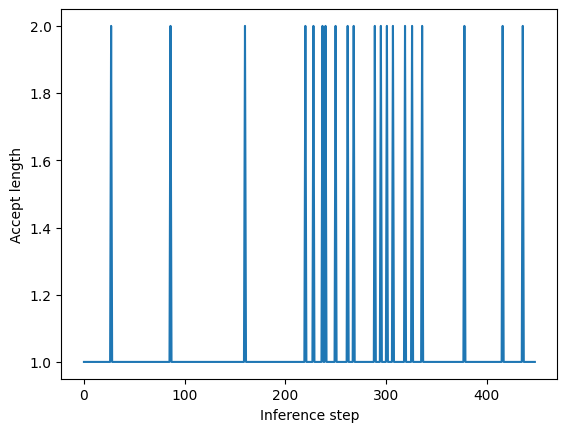

In [28]:
plt.plot(accept_lengths)
plt.xlabel('Inference step')
plt.ylabel('Accept length')
print('Avg. accept length:', np.mean(accept_lengths))

## Unleash the power of Medusa by Tree Attention

Only a 1.58x speedup? You might think that's underwhelming. However, remember what we implemented in the previous section was merely the list structure of Medusa heads. This means we utilized only the Top-1 prediction from each Medusa head. In this section, we will introduce the Tree Attention mechanism, which is the key to unlocking the full potential of Medusa heads. We show a tree structure of Medusa heads below.

<div align="center">
  <picture>
  <img src="../assets/medusa_choices.png" width="100%">
  </picture>
  <br>
  <div align="left" width="80%">
  <em>  We won't dive deep into how this tree was constructed. In simple terms, the tree shows us the optimized paths chosen by an algorithm that looks for the highest accuracy expectations under constraints. At every depth level, childrens from one node moving from left to right shows the top-k selections for each Medusa head. Noticeably, the Top-0 of Medusa head 1 has the most branching out, making the tree tilt more to the left. The left-heavy nature of the tree indicates that the top choices (shallower on the left) tend to have higher accuracy expectations. This suggests that the earliler (head 1 or 2) or topmost (top 1 or 2) choices are more reliable in their predictions. 
  </em>
  </div>
  <br>
</div>

Let's try the tree attention with practical example!

### Initial inference with Medusa heads

In [ ]:
with torch.inference_mode():
    new_token = 0
    input_ids = tokenizer([prompt]).input_ids
    input_len = len(input_ids[0])
    input_ids = torch.as_tensor(input_ids).cuda()
    model.current_length_data.zero_() # this is for rerun
    reset_medusa_mode(model)
    medusa_buffers = generate_medusa_buffers(
                medusa_choices, device=model.base_model.device
            )
    medusa_logits, logits = initialize_medusa(
            input_ids, model, medusa_buffers["medusa_attn_mask"], past_key_values
        )

We have a function `generate_candidates` to retrieve the top-k predictions on the tree.

`tree_candidates` contains the predictions on the nodes of the tree (also include the root node which is the model's head prediction).

The `candidates` are all the paths (total 42) from the root node to the leaf nodes, padded with `<unk>` token.

In [ ]:
candidates, tree_candidates = generate_candidates(
                medusa_logits,
                logits,
                medusa_buffers["tree_indices"],
                medusa_buffers["retrieve_indices"],
            )
print('Candidates shape:', candidates.shape)
print('Tree candidates shape:', tree_candidates.shape)
print('Most left 2 candidates path:', tokenizer.batch_decode(candidates[0]), tokenizer.batch_decode(candidates[1]))
print('Another candidate path:', tokenizer.batch_decode(candidates[-1]))

### Second inference with Medusa heads

Like the previous section, we still need to verify the Medusa heads' prediction. Since we perform the greedy decoding, we set the `temperature` to **0.0** and ignore the `posterior_threshold` and `posterior_alpha` parameters. 

We have two functions, `tree_decoding` and `evaluate_posterior`.

The `tree_decoding` performs the tree-attention-based inference.

The `evaluate_posterior` performs the verification of the tree.

In [ ]:
with torch.inference_mode():
    medusa_logits, logits, outputs = tree_decoding(
                model,
                tree_candidates,
                past_key_values,
                medusa_buffers["medusa_position_ids"],
                input_ids,
                medusa_buffers["retrieve_indices"],
            )
    best_candidate, accept_length = evaluate_posterior(
                logits, candidates, temperature = 0, posterior_threshold = 0, posterior_alpha = 0
            )
    print('Medusa logits shape', medusa_logits.shape)
    print('Logits shape', logits.shape)
    print('Best candidate path index:', best_candidate.item())
    print('Accept length:', accept_length.item())

Let's see how the best candidate path looks like.

In [ ]:
print('Retrieved input @ best candidate:', tokenizer.batch_decode(candidates[best_candidate.item()]))
print('Retrieved output @ best candidate:', tokenizer.batch_decode(logits.argmax(-1)[best_candidate.item()]))

print('Retrieved input @ another candidate:', tokenizer.batch_decode(candidates[0]))
print('Retrieved output @ another candidate:', tokenizer.batch_decode(logits.argmax(-1)[0]))


The verification is very, very similar to what we discussed in the previous section, **shift and compare**. 

Best path looks like this:
<table border="1">
    <thead>
        <tr>
            <th>Input</th>
            <td>'Once'</td>
            <td>'upon'</td>
            <td>'a'</td>
            <td>'time'</td>
            <td>'&lt;unk&gt'</td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>Model output</th>
            <td>'upon'<br>&#9989</td>
            <td>'a'<br>&#9989</td>
            <td>'time'<br>&#9989</td>
            <td>','<br>&#x274C</td>
            <td>'char'<br>&#x274C</td>
        </tr>
    </tbody>
</table>

Another path looks like this:
<table border="1">
    <thead>
        <tr>
            <th>Input</th>
            <td>'Once'</td>
            <td>'upon'</td>
            <td>'ly'</td>
            <td>'time'</td>
            <td>'a'</td>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th>Model output</th>
            <td>'upon'<br>&#9989</td>
            <td>'a'<br>&#9989</td>
            <td>'a'<br>&#x274C</td>
            <td>','<br>&#x274C</td>
            <td>'char'<br>&#x274C</td>
        </tr>
    </tbody>
</table>

The best path contains more accepted tokens, so it win the competition!

Now we will manage the KV cache (as we discussed before) and choose the correct input tokens on the path and it's medusa predictions for next tree.

In [ ]:
input_ids, logits, medusa_logits, new_token = update_inference_inputs(
                input_ids,
                candidates,
                best_candidate,
                accept_length,
                medusa_buffers["retrieve_indices"],
                outputs,
                logits,
                medusa_logits,
                new_token,
                past_key_values_data,
                current_length_data,
            )
print('Decode:', tokenizer.batch_decode(input_ids[:,input_len:]))

### It's time to put all the things together!

Below is the whole process of the tree attention inference. The acceleration ratio is boosted from ~1.6X to ~2.4X!

In [ ]:
accept_lengths_tree = []

with torch.inference_mode():
    new_token = 0
    input_ids = tokenizer([prompt]).input_ids
    input_len = len(input_ids[0])
    input_ids = torch.as_tensor(input_ids).cuda()
    model.current_length_data.zero_() # this is for rerun
    reset_medusa_mode(model)
    medusa_buffers = generate_medusa_buffers(
                medusa_choices, device=model.base_model.device
            )
    medusa_logits, logits = initialize_medusa(
            input_ids, model, medusa_buffers["medusa_attn_mask"], past_key_values
        )
    cur_length = input_len + 1
    accept_lengths_tree.append(1)
    
    for i in range(1024):
        candidates, tree_candidates = generate_candidates(
                medusa_logits,
                logits,
                medusa_buffers["tree_indices"],
                medusa_buffers["retrieve_indices"],
            )
        medusa_logits, logits, outputs = tree_decoding(
                model,
                tree_candidates,
                past_key_values,
                medusa_buffers["medusa_position_ids"],
                input_ids,
                medusa_buffers["retrieve_indices"],
            )
        best_candidate, accept_length = evaluate_posterior(
                logits, candidates, temperature = 0, posterior_threshold = 0, posterior_alpha = 0
            )
        input_ids, logits, medusa_logits, new_token = update_inference_inputs(
                input_ids,
                candidates,
                best_candidate,
                accept_length,
                medusa_buffers["retrieve_indices"],
                outputs,
                logits,
                medusa_logits,
                new_token,
                past_key_values_data,
                current_length_data,
            )
        
        accept_length_tree = input_ids.shape[1] - cur_length
        cur_length = accept_length_tree + cur_length
        accept_lengths_tree.append(accept_length_tree)
        if model.tokenizer.eos_token_id in input_ids[0, input_len:]:
            break
print('Decode:', tokenizer.batch_decode(input_ids[:,input_len:]))

In [ ]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Unsmoothed plots with transparency
plt.plot(accept_lengths_tree, label='Tree decoding (Raw)', alpha=0.3)
plt.plot(accept_lengths, label='List decoding (Raw)', alpha=0.3)

# Smoothed plots
window_size = 5  # You can adjust this as needed
plt.plot(moving_average(accept_lengths_tree, window_size), label='Tree decoding (Smoothed)', color='tab:blue')
plt.plot(moving_average(accept_lengths, window_size), label='List decoding (Smoothed)', color='tab:orange')

plt.xlabel('Inference step')
plt.ylabel('Accept length')
plt.legend()

print('Avg. accept tree length:', np.mean(accept_lengths_tree))
print('Avg. accept list length:', np.mean(accept_lengths))

plt.show()
